In [1]:
#导入相关包
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os
import tensorflow.keras as keras

In [2]:
#获取训练集全部图片
train_img = glob.glob("./dataset/split_train/train/images/*.png") 

In [3]:
train_count = len(train_img)
train_img[:5],train_count

(['./dataset/split_train/train/images\\0.png',
  './dataset/split_train/train/images\\1.png',
  './dataset/split_train/train/images\\100.png',
  './dataset/split_train/train/images\\1000.png',
  './dataset/split_train/train/images\\10000.png'],
 24000)

In [4]:
# 获取训练集全部标签
train_label = glob.glob("./dataset/split_train/train/labels/*.png") 

In [5]:
train_label[:5],len(train_label)

(['./dataset/split_train/train/labels\\0.png',
  './dataset/split_train/train/labels\\1.png',
  './dataset/split_train/train/labels\\100.png',
  './dataset/split_train/train/labels\\1000.png',
  './dataset/split_train/train/labels\\10000.png'],
 24000)

In [6]:
#对训练集图片进行乱序，并确保一一对应
train_index = np.random.permutation(len(train_img))
train_img = np.array(train_img)[train_index] # 对训练集图片进行乱序
train_label = np.array(train_label)[train_index]

In [7]:
#查看一一对应情况
train_img[:5],train_label[:5]

(array(['./dataset/split_train/train/images\\16378.png',
        './dataset/split_train/train/images\\12435.png',
        './dataset/split_train/train/images\\12023.png',
        './dataset/split_train/train/images\\27332.png',
        './dataset/split_train/train/images\\495.png'], dtype='<U44'),
 array(['./dataset/split_train/train/labels\\16378.png',
        './dataset/split_train/train/labels\\12435.png',
        './dataset/split_train/train/labels\\12023.png',
        './dataset/split_train/train/labels\\27332.png',
        './dataset/split_train/train/labels\\495.png'], dtype='<U44'))

In [8]:
#获取验证集全部图片
val_img = glob.glob("./dataset/split_train/val/images/*.png") 
# 获取验证集全部标签
val_label = glob.glob("./dataset/split_train/val/labels/*.png") 

In [9]:
val_img[:5],len(val_img)

(['./dataset/split_train/val/images\\10.png',
  './dataset/split_train/val/images\\10002.png',
  './dataset/split_train/val/images\\10005.png',
  './dataset/split_train/val/images\\10013.png',
  './dataset/split_train/val/images\\10014.png'],
 3000)

In [10]:
val_label[:5],len(val_label)

(['./dataset/split_train/val/labels\\10.png',
  './dataset/split_train/val/labels\\10002.png',
  './dataset/split_train/val/labels\\10005.png',
  './dataset/split_train/val/labels\\10013.png',
  './dataset/split_train/val/labels\\10014.png'],
 3000)

In [11]:
#对训练集图片进行乱序，并确保一一对应
val_index = np.random.permutation(len(val_img))
val_img = np.array(val_img)[val_index] # 对训练集图片进行乱序
val_label = np.array(val_label)[val_index]

In [12]:
#查看一一对应情况
val_img[:5],val_label[:5]

(array(['./dataset/split_train/val/images\\4911.png',
        './dataset/split_train/val/images\\29836.png',
        './dataset/split_train/val/images\\20331.png',
        './dataset/split_train/val/images\\12348.png',
        './dataset/split_train/val/images\\22384.png'], dtype='<U42'),
 array(['./dataset/split_train/val/labels\\4911.png',
        './dataset/split_train/val/labels\\29836.png',
        './dataset/split_train/val/labels\\20331.png',
        './dataset/split_train/val/labels\\12348.png',
        './dataset/split_train/val/labels\\22384.png'], dtype='<U42'))

In [13]:
# 创建数据集
dataset_train = tf.data.Dataset.from_tensor_slices((train_img,train_label))
dataset_val=tf.data.Dataset.from_tensor_slices((val_img,val_label))

In [14]:
# 创建png的解码函数
def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img,channels=3)
    return img

In [15]:
# 创建png的解码函数
def read_png_label(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img,channels=1)
    return img

In [16]:
def normal(img,mask):
    img = tf.cast(img,tf.float32)/127.5-1
    mask = tf.cast(mask,tf.int32)
    return img,mask

In [17]:
# 组装
def load_image(img_path,mask_path):
    img = read_png(img_path)
    mask = read_png_label(mask_path)
    
    img = tf.image.resize(img,(256,256))
    mask = tf.image.resize(mask,(256,256))
    
    img,mask = normal(img,mask)
    
    return img,mask

In [18]:
#参数设置
train_count=len(train_img)
val_count=len(val_img)
BATCH_SIZE = 16
BUFFER_SIZE = 300
step_per_epoch = train_count//BATCH_SIZE
val_step = val_count//BATCH_SIZE

In [19]:
auto = tf.data.experimental.AUTOTUNE # 根据cpu使用情况自动规划线程读取图片

In [20]:
data_train = dataset_train.map(load_image,num_parallel_calls=auto)
data_val = dataset_val.map(load_image,num_parallel_calls=auto)

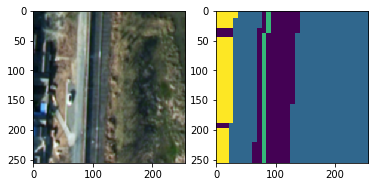

In [21]:
for i,m in data_train.take(1):
    plt.subplot(1,2,1)
    plt.imshow((i.numpy()+1)/2)
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(m.numpy()))

In [22]:
data_train = data_train.repeat().shuffle(24000).batch(BATCH_SIZE)
data_val = data_val.batch(BATCH_SIZE)

In [23]:
def create_model():
    ## unet网络结构下采样部分
    # 输入层 第一部分
    inputs = tf.keras.layers.Input(shape = (256,256,3))
    
    x = tf.keras.layers.Conv2D(32,3,padding="same",activation="relu")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32,3,padding="same",activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)  #  256*256*64
    # 下采样
    x1 = tf.keras.layers.MaxPooling2D(padding="same")(x) # 128*128*64
    x1=tf.keras.layers.Dropout(0.5)(x1)

    # 卷积 第二部分
    x1 = tf.keras.layers.Conv2D(64,3,padding="same",activation="relu")(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Conv2D(64,3,padding="same",activation="relu")(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)  #  128*128*128
    # 下采样 
    x2 = tf.keras.layers.MaxPooling2D(padding="same")(x1) # 64*64*128
    x2=tf.keras.layers.Dropout(0.5)(x2)
        
    # 卷积 第三部分
    x2 = tf.keras.layers.Conv2D(128,3,padding="same",activation="relu")(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.Conv2D(128,3,padding="same",activation="relu")(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)  #  64*64*256
    # 下采样
    x3 = tf.keras.layers.MaxPooling2D(padding="same")(x2) # 32*32*256
    x3=tf.keras.layers.Dropout(0.5)(x3)
    
    # 卷积 第四部分
    x3 = tf.keras.layers.Conv2D(256,3,padding="same",activation="relu")(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)
    x3 = tf.keras.layers.Conv2D(256,3,padding="same",activation="relu")(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)  #  32*32*512
    # 下采样
    x4 = tf.keras.layers.MaxPooling2D(padding="same")(x3) # 16*16*512
    x4=tf.keras.layers.Dropout(0.5)(x4)
    # 卷积  第五部分
    x4 = tf.keras.layers.Conv2D(512,3,padding="same",activation="relu")(x4)
    x4 = tf.keras.layers.BatchNormalization()(x4)
    x4 = tf.keras.layers.Conv2D(512,3,padding="same",activation="relu")(x4)
    x4 = tf.keras.layers.BatchNormalization()(x4)  #  16*16*1024
    x4=tf.keras.layers.Dropout(0.5)(x4)
    
    ## unet网络结构上采样部分
    
    # 反卷积 第一部分      512个卷积核 卷积核大小2*2 跨度2 填充方式same 激活relu
    x5 = tf.keras.layers.Conv2DTranspose(256,2,strides=2,
                                         padding="same",
                                         activation="relu")(x4)#32*32*512
    x5 = tf.keras.layers.BatchNormalization()(x5)
    x5=tf.keras.layers.Dropout(0.5)(x5)
    x6 = tf.concat([x3,x5],axis=-1)#合并 32*32*1024
    # 卷积
    x6 = tf.keras.layers.Conv2D(256,3,padding="same",activation="relu")(x6)
    x6 = tf.keras.layers.BatchNormalization()(x6)
    x6 = tf.keras.layers.Conv2D(256,3,padding="same",activation="relu")(x6)
    x6 = tf.keras.layers.BatchNormalization()(x6)  #  32*32*512
    x6=tf.keras.layers.Dropout(0.5)(x6)
    
    
    # 反卷积 第二部分
    x7 = tf.keras.layers.Conv2DTranspose(128,2,strides=2,
                                         padding="same",
                                         activation="relu")(x6)#64*64*256
    x7 = tf.keras.layers.BatchNormalization()(x7)
    x7=tf.keras.layers.Dropout(0.5)(x7)
    x8 = tf.concat([x2,x7],axis=-1)#合并 64*64*512
    # 卷积
    x8 = tf.keras.layers.Conv2D(128,3,padding="same",activation="relu")(x8)
    x8 = tf.keras.layers.BatchNormalization()(x8)
    x8 = tf.keras.layers.Conv2D(128,3,padding="same",activation="relu")(x8)
    x8 = tf.keras.layers.BatchNormalization()(x8)  #  #64*64*256
    x8=tf.keras.layers.Dropout(0.5)(x8)
    
    # 反卷积 第三部分
    x9 = tf.keras.layers.Conv2DTranspose(64,2,strides=2,
                                         padding="same",
                                         activation="relu")(x8)# 128*128*128
    x9 = tf.keras.layers.BatchNormalization()(x9)
    x9=tf.keras.layers.Dropout(0.5)(x9)
    x10 = tf.concat([x1,x9],axis=-1)#合并 128*128*256
    # 卷积
    x10 = tf.keras.layers.Conv2D(64,3,padding="same",activation="relu")(x10)
    x10 = tf.keras.layers.BatchNormalization()(x10)
    x10 = tf.keras.layers.Conv2D(64,3,padding="same",activation="relu")(x10)
    x10 = tf.keras.layers.BatchNormalization()(x10)  # 128*128*128
    x10=tf.keras.layers.Dropout(0.5)(x10)
    
    # 反卷积 第四部分
    x11 = tf.keras.layers.Conv2DTranspose(32,2,strides=2,
                                         padding="same",
                                         activation="relu")(x10)#  256*256*64
    x11 = tf.keras.layers.BatchNormalization()(x11)
    x11=tf.keras.layers.Dropout(0.5)(x11)
    x12 = tf.concat([x,x11],axis=-1)#合并 256*256*128
    # 卷积
    x12 = tf.keras.layers.Conv2D(32,3,padding="same",activation="relu")(x12)
    x12 = tf.keras.layers.BatchNormalization()(x12)
    x12 = tf.keras.layers.Conv2D(32,3,padding="same",activation="relu")(x12)
    x12 = tf.keras.layers.BatchNormalization()(x12)  # 256*256*64
    x12=tf.keras.layers.Dropout(0.5)(x12)
    
    # 输出层 第五部分
    output =tf.keras.layers.Conv2D(5,1,padding="same",activation="softmax")(x12)# 256*256*34
    
    return tf.keras.Model(inputs=inputs,outputs=output)

In [24]:
model = create_model()

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        batch_normalization[0][0]        
______________________________________________________________________________________________

In [26]:
# 编译模型
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["acc"]
             )

In [27]:
# 导入保存的模型，第二次运行才可以进行的操作
# 给出模型保存的路径以及文件名
model_name = 'Unet'
#checkpoint_save_path = "./checkpoint/{0}-mineral-type{1}.ckpt".format(model_name,len(dirList)) 
checkpoint_save_path = "./model/{0}.ckpt".format(model_name) 
print('模型保存路径：',checkpoint_save_path)

# 读取模型
if os.path.exists(checkpoint_save_path + '.index'):        # 通过索引表判断保存文件是否存在
    print('-------------load the model-----------------')  # 是，则打印"导入模型"
    model.load_weights(checkpoint_save_path)               # 导入模型

模型保存路径： ./model/Unet.ckpt
-------------load the model-----------------


In [28]:
# 保存模型，第一次运行执行这一步操作
model_save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,  # 模型保存路径
                                                          monitor='acc',           # 监视值为 accuracy
                                                         save_weights_only=True,         # 只保留模型参数
                                                         save_best_only=True)            # 只保留最优结果

In [29]:
# 评价指标不在提升时，减少学习率. 当patience个epoch过去而模型性能不提升时，学习率减少的动作会被触发
reduce_lr =  tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', patience=5, verbose=1, mode='auto')

In [30]:
# 当监测值不再改善时，该回调函数将中止训练
earlyStopping_callback = tf.keras.callbacks.EarlyStopping(
    # This callback will monitor the loss of the model
    monitor='loss',
#     min_delta=0.001,
    # Training will be interrupted when the accuracy
    # has stopped improving for *more* than 1 epochs (i.e. 2 epochs)
    patience=20,
    restore_best_weights = True  )# 是否从具有监测数量的最佳值的时期恢复模型权重。 如果为 False，则使用在训练的最后一步获得的模型权重。

In [31]:
# 训练
history = model.fit(data_train,
                    epochs=250,
                    verbose=1,
                    steps_per_epoch=step_per_epoch,
                    validation_steps=val_step,
                    validation_data=data_val,
                    shuffle=True,
                    callbacks=[model_save_callback, reduce_lr, earlyStopping_callback]
                   )

Epoch 1/250
1500/1500 [==============================] - 696s 464ms/step - loss: 1.0864 - acc: 0.5693 - val_loss: 1.3367 - val_acc: 0.4903 - lr: 0.0010
Epoch 2/250
1500/1500 [==============================] - 658s 439ms/step - loss: 0.9026 - acc: 0.6456 - val_loss: 0.9501 - val_acc: 0.6202 - lr: 0.0010
Epoch 3/250
1500/1500 [==============================] - 664s 443ms/step - loss: 0.8121 - acc: 0.6837 - val_loss: 0.8305 - val_acc: 0.6638 - lr: 0.0010
Epoch 4/250
1500/1500 [==============================] - 657s 438ms/step - loss: 0.7556 - acc: 0.7062 - val_loss: 0.6931 - val_acc: 0.7273 - lr: 0.0010
Epoch 5/250
1500/1500 [==============================] - 644s 429ms/step - loss: 0.7078 - acc: 0.7271 - val_loss: 0.6934 - val_acc: 0.7275 - lr: 0.0010
Epoch 6/250
1500/1500 [==============================] - 670s 447ms/step - loss: 0.6710 - acc: 0.7424 - val_loss: 0.7277 - val_acc: 0.7044 - lr: 0.0010
Epoch 7/250
1500/1500 [==============================] - 671s 447ms/step - loss: 0.6411 

1500/1500 [==============================] - 625s 417ms/step - loss: 0.2068 - acc: 0.9191 - val_loss: 0.2547 - val_acc: 0.9039 - lr: 0.0010
Epoch 108/250
1500/1500 [==============================] - 639s 426ms/step - loss: 0.2049 - acc: 0.9197 - val_loss: 0.2894 - val_acc: 0.8966 - lr: 0.0010
Epoch 109/250
1500/1500 [==============================] - 634s 423ms/step - loss: 0.2038 - acc: 0.9204 - val_loss: 0.2587 - val_acc: 0.9043 - lr: 0.0010
Epoch 110/250
1500/1500 [==============================] - 639s 426ms/step - loss: 0.2066 - acc: 0.9195 - val_loss: 0.2610 - val_acc: 0.9024 - lr: 0.0010
Epoch 111/250
1500/1500 [==============================] - 636s 424ms/step - loss: 0.2028 - acc: 0.9206 - val_loss: 0.2647 - val_acc: 0.9041 - lr: 0.0010
Epoch 112/250
1500/1500 [==============================] - 635s 423ms/step - loss: 0.2035 - acc: 0.9205 - val_loss: 0.2637 - val_acc: 0.9035 - lr: 0.0010
Epoch 113/250
1500/1500 [==============================] - 663s 442ms/step - loss: 0.2009 

Epoch 205/250
1500/1500 [==============================] - 637s 425ms/step - loss: 0.1572 - acc: 0.9373 - val_loss: 0.2388 - val_acc: 0.9168 - lr: 1.0000e-10
Epoch 206/250
1500/1500 [==============================] - ETA: 0s - loss: 0.1572 - acc: 0.9373
Epoch 00206: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.
1500/1500 [==============================] - 629s 419ms/step - loss: 0.1572 - acc: 0.9373 - val_loss: 0.2389 - val_acc: 0.9169 - lr: 1.0000e-10
Epoch 207/250
1500/1500 [==============================] - 638s 425ms/step - loss: 0.1583 - acc: 0.9368 - val_loss: 0.2396 - val_acc: 0.9168 - lr: 1.0000e-11
Epoch 208/250
1500/1500 [==============================] - 634s 423ms/step - loss: 0.1567 - acc: 0.9374 - val_loss: 0.2388 - val_acc: 0.9168 - lr: 1.0000e-11


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
# 保存训练的日志文件
pd.DataFrame(history.history).to_csv('une_ttraining_log.csv', index=False)

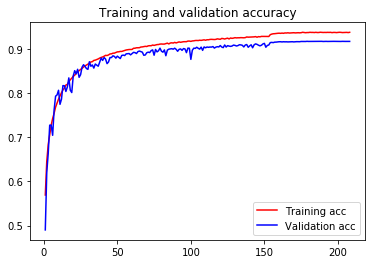

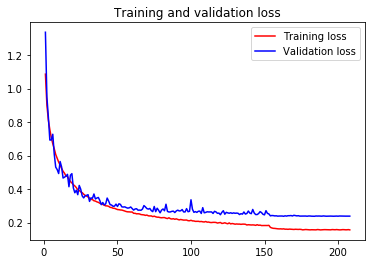

In [33]:
#  保存并绘制loss,acc
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("unetaccuracy.png", dpi = 300)
plt.figure()
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("unetloss.png", dpi = 300)
plt.show()

In [28]:
images_test=glob.glob('./dataset/split_train/test/images/*.png')
labels_test=glob.glob('./dataset/split_train/test/labels/*.png')

In [29]:
index = np.random.permutation(len(images_test))
images_test = np.array(images_test)[index] # 对训练集图片进行乱序
labels_test = np.array(labels_test)[index]

In [30]:
# 创建数据集
dataset1 = tf.data.Dataset.from_tensor_slices((images_test,labels_test))

In [31]:
dataset1 = dataset1.map(load_image,num_parallel_calls=auto)
dataset1 = dataset1.batch(BATCH_SIZE)

In [32]:
preds=model.evaluate(dataset1)#U-Net

188/188 [==============================] - 14s 74ms/step - loss: 0.2392 - acc: 0.9190


In [32]:
import seaborn as sn
import pandas as pd
def fast_hist(a, b, n):
    #k为掩膜（去除了255这些点（即标签图中的白色的轮廓），其中的a>=0是为了防止bincount()函数出错）
    k = (a >= 0) & (a < n) 
    #bincount()函数用于统计数组内每个非负整数的个数
    #详见https://docs.scipy.org/doc/numpy/reference/generated/numpy.bincount.html
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n**2).reshape(n, n) #核心代码

In [35]:
c=pd.DataFrame({'0':[0,0,0,0,0],'1':[0,0,0,0,0],'2':[0,0,0,0,0],'3':[0,0,0,0,0],'4':[0,0,0,0,0]},index=[0,1,2,3,4])
for image, mask in dataset1.take(188): # 从test数据取出一个batch
    pred_mask = model.predict(image) # model.predict(image) 对图片进行预测
    pred_mask = tf.argmax(pred_mask, axis=-1)  # 取出预测最大值
    pred_mask = pred_mask[..., tf.newaxis] # 维度扩展 取前面所有维度
    print(pred_mask.shape)
    print(mask.shape)
    mask=np.array(mask).reshape(-1)
    pred_mask=np.array(pred_mask).reshape(-1)
    print(pred_mask.shape)
    print(mask.shape)
    a=fast_hist(mask,pred_mask,5)
    df_cm = pd.DataFrame(a)
    c=pd.concat([c,df_cm])
    print(c)

(16, 256, 256, 1)
(16, 256, 256, 1)
(1048576,)
(1048576,)
     0    1    2    3    4        0         1        2         3        4
0  0.0  0.0  0.0  0.0  0.0      NaN       NaN      NaN       NaN      NaN
1  0.0  0.0  0.0  0.0  0.0      NaN       NaN      NaN       NaN      NaN
2  0.0  0.0  0.0  0.0  0.0      NaN       NaN      NaN       NaN      NaN
3  0.0  0.0  0.0  0.0  0.0      NaN       NaN      NaN       NaN      NaN
4  0.0  0.0  0.0  0.0  0.0      NaN       NaN      NaN       NaN      NaN
0  NaN  NaN  NaN  NaN  NaN  52369.0    2583.0   1538.0    8627.0      0.0
1  NaN  NaN  NaN  NaN  NaN   1216.0  623617.0    941.0    4298.0   3223.0
2  NaN  NaN  NaN  NaN  NaN   1334.0    1652.0  82657.0    1246.0      0.0
3  NaN  NaN  NaN  NaN  NaN   6145.0    6988.0    825.0  147019.0      0.0
4  NaN  NaN  NaN  NaN  NaN     19.0    3014.0      0.0       0.0  99265.0
(16, 256, 256, 1)
(16, 256, 256, 1)
(1048576,)
(1048576,)
          0         1        2         3        4    0    1    2    3 

(16, 256, 256, 1)
(16, 256, 256, 1)
(1048576,)
(1048576,)
          0         1         2         3         4    0    1    2    3    4
0       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
1       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
2       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
3       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
4       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
0   52369.0    2583.0    1538.0    8627.0       0.0  NaN  NaN  NaN  NaN  NaN
1    1216.0  623617.0     941.0    4298.0    3223.0  NaN  NaN  NaN  NaN  NaN
2    1334.0    1652.0   82657.0    1246.0       0.0  NaN  NaN  NaN  NaN  NaN
3    6145.0    6988.0     825.0  147019.0       0.0  NaN  NaN  NaN  NaN  NaN
4      19.0    3014.0       0.0       0.0   99265.0  NaN  NaN  NaN  NaN  NaN
0  189201.0    7324.0    7037.0   32949.0     316.0  NaN  NaN  NaN  NaN  NaN
1    6487.0  41274

(16, 256, 256, 1)
(16, 256, 256, 1)
(1048576,)
(1048576,)
          0         1         2         3         4    0    1    2    3    4
0       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
1       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
2       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
3       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
4       NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
0   52369.0    2583.0    1538.0    8627.0       0.0  NaN  NaN  NaN  NaN  NaN
1    1216.0  623617.0     941.0    4298.0    3223.0  NaN  NaN  NaN  NaN  NaN
2    1334.0    1652.0   82657.0    1246.0       0.0  NaN  NaN  NaN  NaN  NaN
3    6145.0    6988.0     825.0  147019.0       0.0  NaN  NaN  NaN  NaN  NaN
4      19.0    3014.0       0.0       0.0   99265.0  NaN  NaN  NaN  NaN  NaN
0  189201.0    7324.0    7037.0   32949.0     316.0  NaN  NaN  NaN  NaN  NaN
1    6487.0  41274

(16, 256, 256, 1)
(16, 256, 256, 1)
(1048576,)
(1048576,)
           0         1        2         3        4    0    1    2    3    4
0        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...      ...  ...  ...  ...  ...  ...
0   347945.0   10212.0   8732.0   23004.0     67.0  NaN  NaN  NaN  NaN  NaN
1     3448.0  405230.0     15.0    1114.0   2063.0  NaN  NaN  NaN  NaN  NaN
2     5815.0     455.0  47545.0     310.0      0.0  NaN  NaN  NaN  NaN  NaN
3    14500.0     709.0    273.0  152664.0      0.0  NaN  NaN  NaN  NaN  NaN
4        0.0    1676.0      0.0       0.0  22799.0  NaN  NaN  NaN  NaN  NaN

[65 rows x 10 columns]
(16, 2

(16, 256, 256, 1)
(16, 256, 256, 1)
(1048576,)
(1048576,)
           0         1        2         3        4    0    1    2    3    4
0        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...      ...  ...  ...  ...  ...  ...
0   340109.0    2572.0   9496.0   27636.0    537.0  NaN  NaN  NaN  NaN  NaN
1     1160.0  250698.0      0.0     161.0    151.0  NaN  NaN  NaN  NaN  NaN
2     6163.0      19.0  83275.0      94.0      0.0  NaN  NaN  NaN  NaN  NaN
3    21040.0     426.0     88.0  279434.0      0.0  NaN  NaN  NaN  NaN  NaN
4     2070.0    1642.0    154.0     258.0  21393.0  NaN  NaN  NaN  NaN  NaN

[115 rows x 10 columns]
(16, 

(16, 256, 256, 1)
(16, 256, 256, 1)
(1048576,)
(1048576,)
           0         1        2         3       4    0    1    2    3    4
0        NaN       NaN      NaN       NaN     NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN     NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN     NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN     NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN     NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...     ...  ...  ...  ...  ...  ...
0   348307.0    9531.0   7645.0   40127.0     0.0  NaN  NaN  NaN  NaN  NaN
1     2210.0  340419.0      6.0    8401.0   247.0  NaN  NaN  NaN  NaN  NaN
2     3693.0       0.0  18888.0     400.0     0.0  NaN  NaN  NaN  NaN  NaN
3    24248.0    3679.0    209.0  233279.0     0.0  NaN  NaN  NaN  NaN  NaN
4        0.0     620.0      0.0       0.0  6667.0  NaN  NaN  NaN  NaN  NaN

[160 rows x 10 columns]
(16, 256, 256, 1)

(1048576,)
(1048576,)
           0         1        2         3        4    0    1    2    3    4
0        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...      ...  ...  ...  ...  ...  ...
0   243319.0    2235.0   5803.0   35471.0    450.0  NaN  NaN  NaN  NaN  NaN
1     2504.0  367574.0      0.0     867.0   2245.0  NaN  NaN  NaN  NaN  NaN
2     3256.0       0.0  45098.0       0.0      0.0  NaN  NaN  NaN  NaN  NaN
3    22045.0    1846.0      9.0  269395.0   1962.0  NaN  NaN  NaN  NaN  NaN
4      270.0    1686.0      0.0       0.0  42541.0  NaN  NaN  NaN  NaN  NaN

[205 rows x 10 columns]
(16, 256, 256, 1)
(16, 256, 256, 1)
(1048

(16, 256, 256, 1)
(16, 256, 256, 1)
(1048576,)
(1048576,)
           0         1        2         3        4    0    1    2    3    4
0        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...      ...  ...  ...  ...  ...  ...
0   330692.0    5378.0   5818.0   19273.0   2112.0  NaN  NaN  NaN  NaN  NaN
1     4312.0  276511.0      0.0    2149.0   3543.0  NaN  NaN  NaN  NaN  NaN
2     9192.0      48.0  48921.0     858.0      0.0  NaN  NaN  NaN  NaN  NaN
3    17339.0    2374.0    823.0  236158.0      0.0  NaN  NaN  NaN  NaN  NaN
4      466.0    2746.0      0.0       0.0  79863.0  NaN  NaN  NaN  NaN  NaN

[255 rows x 10 columns]
(16, 

(16, 256, 256, 1)
(16, 256, 256, 1)
(1048576,)
(1048576,)
           0         1        2         3        4    0    1    2    3    4
0        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...      ...  ...  ...  ...  ...  ...
0   236227.0   15804.0   2448.0   32808.0    991.0  NaN  NaN  NaN  NaN  NaN
1     7480.0  321978.0   3083.0    3038.0   4154.0  NaN  NaN  NaN  NaN  NaN
2     5388.0    1400.0  56498.0     190.0      0.0  NaN  NaN  NaN  NaN  NaN
3    13837.0    2111.0      0.0  269078.0      0.0  NaN  NaN  NaN  NaN  NaN
4      443.0    4124.0      0.0     284.0  67212.0  NaN  NaN  NaN  NaN  NaN

[305 rows x 10 columns]
(16, 

(16, 256, 256, 1)
(16, 256, 256, 1)
(1048576,)
(1048576,)
           0         1        2         3        4    0    1    2    3    4
0        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...      ...  ...  ...  ...  ...  ...
0   368964.0    2843.0   5245.0   23152.0    371.0  NaN  NaN  NaN  NaN  NaN
1     2061.0  281675.0   1720.0     923.0    395.0  NaN  NaN  NaN  NaN  NaN
2    11613.0     824.0  97634.0    2631.0      0.0  NaN  NaN  NaN  NaN  NaN
3    17910.0    2326.0      0.0  212019.0      0.0  NaN  NaN  NaN  NaN  NaN
4        0.0     713.0      0.0       0.0  15557.0  NaN  NaN  NaN  NaN  NaN

[350 rows x 10 columns]
(16, 

(16, 256, 256, 1)
(16, 256, 256, 1)
(1048576,)
(1048576,)
           0         1         2         3        4    0    1    2    3    4
0        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN       NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...       ...       ...      ...  ...  ...  ...  ...  ...
0   333891.0    2248.0    7899.0   26421.0      3.0  NaN  NaN  NaN  NaN  NaN
1     2022.0  297469.0     358.0    3692.0    298.0  NaN  NaN  NaN  NaN  NaN
2    15776.0     451.0  111094.0    3037.0      0.0  NaN  NaN  NaN  NaN  NaN
3    16115.0    2397.0     123.0  205362.0     99.0  NaN  NaN  NaN  NaN  NaN
4        0.0    2667.0       0.0     615.0  16539.0  NaN  NaN  NaN  NaN  NaN

[395 rows x 10 co

(16, 256, 256, 1)
(16, 256, 256, 1)
(1048576,)
(1048576,)
           0         1         2         3         4    0    1    2    3    4
0        NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN       NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...       ...       ...       ...  ...  ...  ...  ...  ...
0   292986.0    1341.0    7944.0   22421.0     865.0  NaN  NaN  NaN  NaN  NaN
1      606.0  277995.0     430.0       0.0     258.0  NaN  NaN  NaN  NaN  NaN
2    11829.0     231.0  103631.0      28.0       0.0  NaN  NaN  NaN  NaN  NaN
3    17053.0      16.0     339.0  185661.0       0.0  NaN  NaN  NaN  NaN  NaN
4     2937.0     574.0       0.0       7.0  121424.0  NaN  NaN  NaN  NaN  NaN

[440 

(16, 256, 256, 1)
(16, 256, 256, 1)
(1048576,)
(1048576,)
           0         1    2         3         4    0    1    2    3    4
0        NaN       NaN  NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN  NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN  NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN  NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN  NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...  ...       ...       ...  ...  ...  ...  ...  ...
0   220968.0    2646.0  8.0   15766.0    2224.0  NaN  NaN  NaN  NaN  NaN
1     1035.0  425517.0  0.0    2117.0     627.0  NaN  NaN  NaN  NaN  NaN
2      463.0       0.0  2.0       7.0       0.0  NaN  NaN  NaN  NaN  NaN
3    14073.0    6385.0  0.0  244989.0       0.0  NaN  NaN  NaN  NaN  NaN
4     1085.0    1549.0  0.0       0.0  109115.0  NaN  NaN  NaN  NaN  NaN

[485 rows x 10 columns]
(16, 256, 256, 1)
(16, 256, 256, 1)
(1048

(16, 256, 256, 1)
(16, 256, 256, 1)
(1048576,)
(1048576,)
           0         1        2         3        4    0    1    2    3    4
0        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...      ...  ...  ...  ...  ...  ...
0   223396.0    5955.0   5126.0   12541.0    404.0  NaN  NaN  NaN  NaN  NaN
1     2860.0  417633.0     53.0    4121.0   1226.0  NaN  NaN  NaN  NaN  NaN
2     2962.0     117.0  90404.0      21.0      0.0  NaN  NaN  NaN  NaN  NaN
3    12801.0    1356.0      0.0  174181.0      0.0  NaN  NaN  NaN  NaN  NaN
4      710.0    3809.0      0.0       0.0  88900.0  NaN  NaN  NaN  NaN  NaN

[530 rows x 10 columns]
(16, 

(16, 256, 256, 1)
(16, 256, 256, 1)
(1048576,)
(1048576,)
           0         1        2         3         4    0    1    2    3    4
0        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN       NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...       ...  ...  ...  ...  ...  ...
0   272565.0    2071.0   8130.0   14239.0     736.0  NaN  NaN  NaN  NaN  NaN
1     5253.0  303334.0   1049.0    4429.0    3238.0  NaN  NaN  NaN  NaN  NaN
2     3734.0    2997.0  42393.0     205.0       8.0  NaN  NaN  NaN  NaN  NaN
3    13483.0    2474.0   1218.0  262502.0       0.0  NaN  NaN  NaN  NaN  NaN
4      656.0    3082.0      0.0      15.0  100765.0  NaN  NaN  NaN  NaN  NaN

[575 rows x 10 co

(16, 256, 256, 1)
(16, 256, 256, 1)
(1048576,)
(1048576,)
           0         1        2         3        4    0    1    2    3    4
0        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...      ...  ...  ...  ...  ...  ...
0   318775.0    7306.0   5029.0   21812.0    139.0  NaN  NaN  NaN  NaN  NaN
1    11072.0  260012.0     60.0   10336.0    985.0  NaN  NaN  NaN  NaN  NaN
2     9661.0    2851.0  98643.0     491.0      0.0  NaN  NaN  NaN  NaN  NaN
3    21041.0    2192.0    326.0  255136.0      0.0  NaN  NaN  NaN  NaN  NaN
4      577.0     700.0     27.0       0.0  21405.0  NaN  NaN  NaN  NaN  NaN

[625 rows x 10 columns]
(16, 

(16, 256, 256, 1)
(16, 256, 256, 1)
(1048576,)
(1048576,)
           0         1        2         3        4    0    1    2    3    4
0        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...      ...  ...  ...  ...  ...  ...
0   275838.0    7730.0   7871.0   33750.0   1958.0  NaN  NaN  NaN  NaN  NaN
1     2772.0  379624.0   1251.0    4055.0   1026.0  NaN  NaN  NaN  NaN  NaN
2     5299.0    2334.0  42094.0     172.0      0.0  NaN  NaN  NaN  NaN  NaN
3    20741.0    1874.0    324.0  199365.0      0.0  NaN  NaN  NaN  NaN  NaN
4     2002.0    4801.0      0.0       0.0  53695.0  NaN  NaN  NaN  NaN  NaN

[675 rows x 10 columns]
(16, 

(16, 256, 256, 1)
(16, 256, 256, 1)
(1048576,)
(1048576,)
           0         1        2         3        4    0    1    2    3    4
0        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...      ...  ...  ...  ...  ...  ...
0   293196.0    9061.0   7137.0   21781.0    594.0  NaN  NaN  NaN  NaN  NaN
1     4352.0  380792.0   5570.0    1995.0    802.0  NaN  NaN  NaN  NaN  NaN
2     5293.0    2649.0  57981.0     427.0      0.0  NaN  NaN  NaN  NaN  NaN
3    13247.0    2393.0    282.0  171015.0      0.0  NaN  NaN  NaN  NaN  NaN
4      869.0    2275.0      0.0     163.0  66702.0  NaN  NaN  NaN  NaN  NaN

[725 rows x 10 columns]
(16, 

(1048576,)
(1048576,)
           0         1       2         3        4    0    1    2    3    4
0        NaN       NaN     NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN     NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN     NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN     NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN     NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...     ...       ...      ...  ...  ...  ...  ...  ...
0   334437.0   12777.0  4343.0   16437.0   2492.0  NaN  NaN  NaN  NaN  NaN
1     7707.0  398772.0    43.0     565.0   1231.0  NaN  NaN  NaN  NaN  NaN
2     1892.0    1673.0  4838.0       0.0      0.0  NaN  NaN  NaN  NaN  NaN
3    16808.0    1953.0   496.0  166690.0      3.0  NaN  NaN  NaN  NaN  NaN
4     2271.0    4562.0     0.0       0.0  68586.0  NaN  NaN  NaN  NaN  NaN

[770 rows x 10 columns]
(16, 256, 256, 1)
(16, 256, 256, 1)
(1048576,)
(10485

(16, 256, 256, 1)
(16, 256, 256, 1)
(1048576,)
(1048576,)
           0         1        2         3        4    0    1    2    3    4
0        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...      ...  ...  ...  ...  ...  ...
0   333041.0    3259.0   3774.0   40719.0    660.0  NaN  NaN  NaN  NaN  NaN
1     3688.0  265652.0     47.0    5382.0   1924.0  NaN  NaN  NaN  NaN  NaN
2     7079.0     114.0  23386.0     303.0      0.0  NaN  NaN  NaN  NaN  NaN
3    20277.0    2677.0    267.0  252419.0      0.0  NaN  NaN  NaN  NaN  NaN
4      898.0    4707.0    122.0     272.0  77909.0  NaN  NaN  NaN  NaN  NaN

[820 rows x 10 columns]
(16, 

(16, 256, 256, 1)
(16, 256, 256, 1)
(1048576,)
(1048576,)
           0         1        2         3        4    0    1    2    3    4
0        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...      ...  ...  ...  ...  ...  ...
0   159604.0    5514.0   7097.0   13106.0     68.0  NaN  NaN  NaN  NaN  NaN
1     1490.0  623930.0    401.0    2369.0   1271.0  NaN  NaN  NaN  NaN  NaN
2     6896.0    1226.0  46737.0     150.0     45.0  NaN  NaN  NaN  NaN  NaN
3    11828.0    3004.0    752.0  127868.0      0.0  NaN  NaN  NaN  NaN  NaN
4        0.0    8194.0      0.0       0.0  27026.0  NaN  NaN  NaN  NaN  NaN

[865 rows x 10 columns]
(16, 

(16, 256, 256, 1)
(16, 256, 256, 1)
(1048576,)
(1048576,)
           0         1        2         3        4    0    1    2    3    4
0        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
1        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
2        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
3        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
4        NaN       NaN      NaN       NaN      NaN  0.0  0.0  0.0  0.0  0.0
..       ...       ...      ...       ...      ...  ...  ...  ...  ...  ...
0   186550.0    4537.0   3003.0   14599.0    295.0  NaN  NaN  NaN  NaN  NaN
1     2057.0  588229.0    248.0    3118.0   1308.0  NaN  NaN  NaN  NaN  NaN
2     4860.0     562.0  14008.0     325.0     88.0  NaN  NaN  NaN  NaN  NaN
3     6970.0    5816.0      0.0  177725.0      0.0  NaN  NaN  NaN  NaN  NaN
4      485.0    4539.0      0.0      12.0  29242.0  NaN  NaN  NaN  NaN  NaN

[915 rows x 10 columns]
(16, 

In [36]:
c.groupby(c.index).sum().reset_index()

,index,0,1,2,3,4,0,1,2,3,4
0,0,51790157.0,1267027.0,1381109.0,4926313.0,149363.0,0.0,0.0,0.0,0.0,0.0
1,1,829921.0,61770563.0,166309.0,591897.0,327327.0,0.0,0.0,0.0,0.0,0.0
2,2,1175328.0,179805.0,11127079.0,125561.0,2967.0,0.0,0.0,0.0,0.0,0.0
3,3,3379875.0,614483.0,71375.0,43356367.0,17757.0,0.0,0.0,0.0,0.0,0.0
4,4,152733.0,532606.0,3559.0,38431.0,12630088.0,0.0,0.0,0.0,0.0,0.0
